# WIP: Balance Dataset (All Data)

In [1]:
!pip install -q PyAthena==1.10.7

In [2]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [3]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Download All Data from Public S3 Bucket to Private S3 Bucket

In [36]:
# Public bucket
s3_source_path_tsv = 's3://amazon-reviews-pds/tsv'

In [60]:
# Private bucket for this AWS account
s3_destination_path_tsv_all = 's3://{}/amazon-reviews-pds/tsv-all'.format(bucket)
print(s3_destination_path_tsv_all)

s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all


In [53]:
!aws s3 cp --recursive $s3_source_path_tsv/ $s3_destination_path_tsv_all/ --exclude "*" --include "amazon_reviews_us_*.tsv.gz"

copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Baby_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Baby_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Automotive_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Apparel_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Beauty_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Camera_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz to s3://sagemaker-us-east-1-83531

copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Video_DVD_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Video_DVD_v1_00.tsv.gz
copy: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz to s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all/amazon_reviews_us_Wireless_v1_00.tsv.gz


In [54]:
!aws s3 ls $s3_destination_path_tsv_all/

2020-08-18 20:56:00  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2020-08-18 20:56:00  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2020-08-18 20:56:00  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2020-08-18 20:56:00  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2020-08-18 20:56:00 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2020-08-18 20:56:08 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2020-08-18 20:56:13 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2020-08-18 20:56:14  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2020-08-18 20:56:20 2689739299 amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv.gz
2020-08-18 20:56:24 1294879074 amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz
2020-08-18 20:56:41  253570168 amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz
2020-08-18 20:56:46   18997559 amazon_reviews_us_Digital_Software_v1_00.tsv.gz
2020-08-18 20:56:47  506979922 amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz
2020-08-18 20:56:51   2744264

In [68]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Set Athena database & table 
database_name = 'dsoaws'
table_name_tsv_all = 'amazon_reviews_tsv_all'

In [69]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         marketplace string,
         customer_id string,
         review_id string,
         product_id string,
         product_parent string,
         product_title string,
         product_category string,
         star_rating int,
         helpful_votes int,
         total_votes int,
         vine string,
         verified_purchase string,
         review_headline string,
         review_body string,
         review_date string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\\t' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(database_name, table_name_tsv_all, s3_destination_path_tsv_all)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS dsoaws.amazon_reviews_tsv_all(
         marketplace string,
         customer_id string,
         review_id string,
         product_id string,
         product_parent string,
         product_title string,
         product_category string,
         star_rating int,
         helpful_votes int,
         total_votes int,
         vine string,
         verified_purchase string,
         review_headline string,
         review_body string,
         review_date string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv-all'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')


In [71]:
# Execute statement using connection cursor
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

#### Verify that the table has been created successfully.m

In [73]:
statement = 'SHOW TABLES in {}'.format(database_name)
cursor.execute(statement)

df_show = as_pandas(cursor)
df_show.head(10)

,tab_name
0,amazon_reviews_parquet
1,amazon_reviews_sampled_star1
2,amazon_reviews_sampled_star2
3,amazon_reviews_sampled_star3
4,amazon_reviews_sampled_star4
5,amazon_reviews_sampled_star5
6,amazon_reviews_tsv
7,amazon_reviews_tsv_all
8,temp_table_fc2bf2cbd1b845ad9a990755abb0a9fb


# Number of Reviews per Product Category and Star Rating? 

In [74]:
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name_tsv_all)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_tsv_all
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [75]:
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

In [76]:
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Apparel,5,3320566
1,Apparel,4,1147237
2,Apparel,3,623471
3,Apparel,2,369601
4,Apparel,1,445458
...,...,...,...
210,Wireless,5,4824783
211,Wireless,4,1501327
212,Wireless,3,815205
213,Wireless,2,598330


# Balance the Dataset

## Find min() number of Reviews per Star Rating (grouped by Star Rating)

In [77]:
df_sum = df.groupby(['star_rating']).sum()
print(df_sum)

             count_reviews
star_rating               
1                 12099639
2                  7304430
3                 12133927
4                 26223470
5                 93200812


In [78]:
review_minimum = df_sum['count_reviews'].min()
print("\n Minimum number of reviews: " + str(review_minimum))


 Minimum number of reviews: 7304430


## Find absolute min() number of Reviews per Star Rating (across Product Categories)

In [79]:
df_min = df.loc[df.groupby('star_rating')['count_reviews'].idxmin()]
print(df_min)

review_minimum_2 = df_min['count_reviews'].min()
print("\n Minimum number of reviews: " + str(review_minimum_2))

    product_category  star_rating  count_reviews
69         Gift Card            1           4793
68         Gift Card            2           1569
67         Gift Card            3           3156
66         Gift Card            4           9859
40  Digital_Software            5          46410

 Minimum number of reviews: 1569


# Pick number N (min) of Reviews per Star Rating 

## ---- Using Stratified Reservoir Sampling ----
See https://ragrawal.wordpress.com/2017/08/11/data-sampling-in-presto/  
Select min() number of reviews (randomized) from each star rating group. 

In [87]:
statement = """
SELECT star_rating,
         review_body,
         product_category
FROM 
    (SELECT *,
         ROW_NUMBER()
        OVER (PARTITION BY star_rating
    ORDER BY  rnd) AS rnk
    FROM 
        (SELECT star_rating,
         review_body,
         product_category,
         RANDOM() AS rnd
        FROM {}.{} ) bucketed ) sampled
    WHERE rnk <= {}
""".format(database_name, table_name_tsv_all, review_minimum)

print(statement)


SELECT star_rating,
         review_body,
         product_category
FROM 
    (SELECT *,
         ROW_NUMBER()
        OVER (PARTITION BY star_rating
    ORDER BY  rnd) AS rnk
    FROM 
        (SELECT star_rating,
         review_body,
         product_category,
         RANDOM() AS rnd
        FROM dsoaws.amazon_reviews_tsv_all ) bucketed ) sampled
    WHERE rnk <= 7304430



In [88]:
%%time
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

OperationalError: Query exhausted resources at this scale factor

In [82]:
df_balanced = as_pandas(cursor)

In [83]:
df_balanced.head()

,star_rating,review_body,product_category
0,2,Didn't pack TOTS,Digital_Video_Games
1,2,"It's a \\""total\\"" console port game , no vide...",Digital_Video_Games
2,2,If you are going to draw people in full color ...,Digital_Video_Games
3,2,Played game years ago and loved it. Wanted it ...,Digital_Video_Games
4,2,The download did not have all of the disk feat...,Digital_Video_Games


## CHECK: Number of Reviews per Star Rating

Text(0, 0.5, 'Review Count')

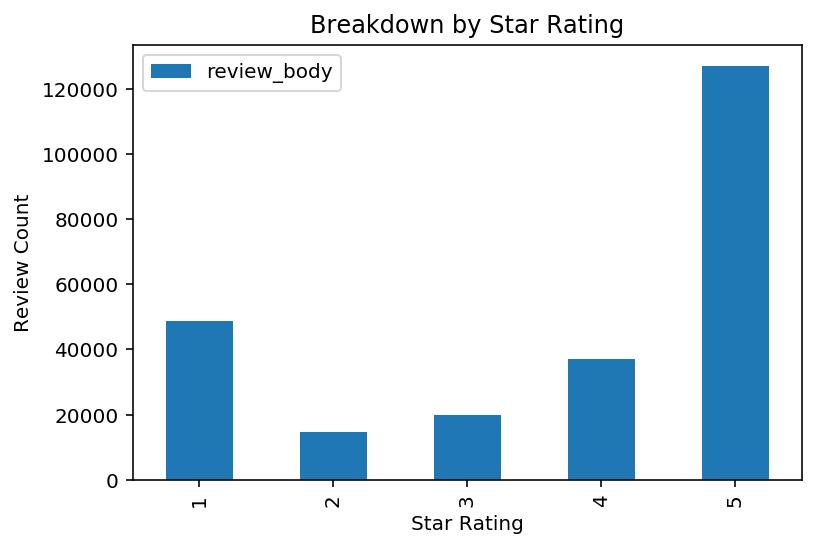

In [84]:
df_balanced[['star_rating', 'review_body']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

## ---- Using Athena CTAS Query ----

In [102]:
table_name_tsv_balanced = 'amazon_reviews_balanced'

In [115]:
statement = """
CREATE TABLE IF NOT EXISTS {}.{}
WITH ( format = 'TEXTFILE', external_location = 's3://{}/amazon-reviews-pds/balanced/', field_delimiter = '\\t' ) AS
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 1
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 2
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 3
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 4
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 5
LIMIT {}
""".format(database_name, table_name_tsv_balanced, bucket, review_minimum)
#           review_minimum,
#           review_minimum,
#           review_minimum,
#           review_minimum)

print(statement)


CREATE TABLE IF NOT EXISTS dsoaws.amazon_reviews_balanced
WITH ( format = 'TEXTFILE', external_location = 's3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/balanced/', field_delimiter = '\t' ) AS
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 1
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 2
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 3
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 4
UNION
SELECT review_body,
         product_category,
         star_rating
FROM dsoaws.amazon_reviews_tsv_all TABLESAMPLE BERNOULLI (10)
WHERE star_rating = 5
LIMIT 73044

In [122]:
%%time

cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)


CPU times: user 89.3 ms, sys: 12.7 ms, total: 102 ms
Wall time: 17.6 s


In [123]:
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name_tsv_balanced)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_balanced
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [124]:
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

In [125]:
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Apparel,5,332418
1,Apparel,4,114378
2,Apparel,3,62190
3,Apparel,2,37148
4,Apparel,1,44960
...,...,...,...
210,Wireless,5,482334
211,Wireless,4,150543
212,Wireless,3,81254
213,Wireless,2,60067


In [126]:
df_sum = df.groupby(['star_rating']).sum()
print(df_sum)

             count_reviews
star_rating               
1                  1211333
2                   730172
3                  1213001
4                  2622554
5                  9317910


In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();